<a href="https://colab.research.google.com/github/Asma-Ahmed-Aqil-AL-Zubaidi/Mini_project_week5/blob/main/mine_project_week_5_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [81]:
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import seaborn as sns

In [ ]:
SEED=42

### About Dataset

The dataset represents synthetic traffic data for a certain location over a one-year period. It includes information about the traffic volume, weather conditions, and special events that may affect traffic.

Features:

Timestamp: The date and time of the observation.Weather: The weather condition at the time of the observation (e.g., Clear, Cloudy, Rain, Snow).

Events: A binary variable indicating whether there was a special event affecting traffic at the time of the observation (True or False).

Traffic Volume: The volume of traffic at the location at the time of the observation.

The dataset is intended for use in analyzing traffic patterns and trends, as well as for developing and testing models related to traffic prediction and management.

In [7]:
df=pd.read_csv('/content/drive/MyDrive/mine progect/traffic_dataset_with_trend.csv',parse_dates=["Timestamp"])

In [9]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1RoB9_EDA1qbye6ZSs_aponREaOj7BFhZDO-xgOnNbcQ#gid=0


/usr/local/lib/python3.10/dist-packages/google/colab/sheets.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return frame.applymap(_clean_val).replace({np.nan: None})


In [6]:
df.columns

Index(['Timestamp', 'Weather', 'Events', 'Traffic Volume'], dtype='object')

In [83]:
df.shape

(8736, 3)

### insight
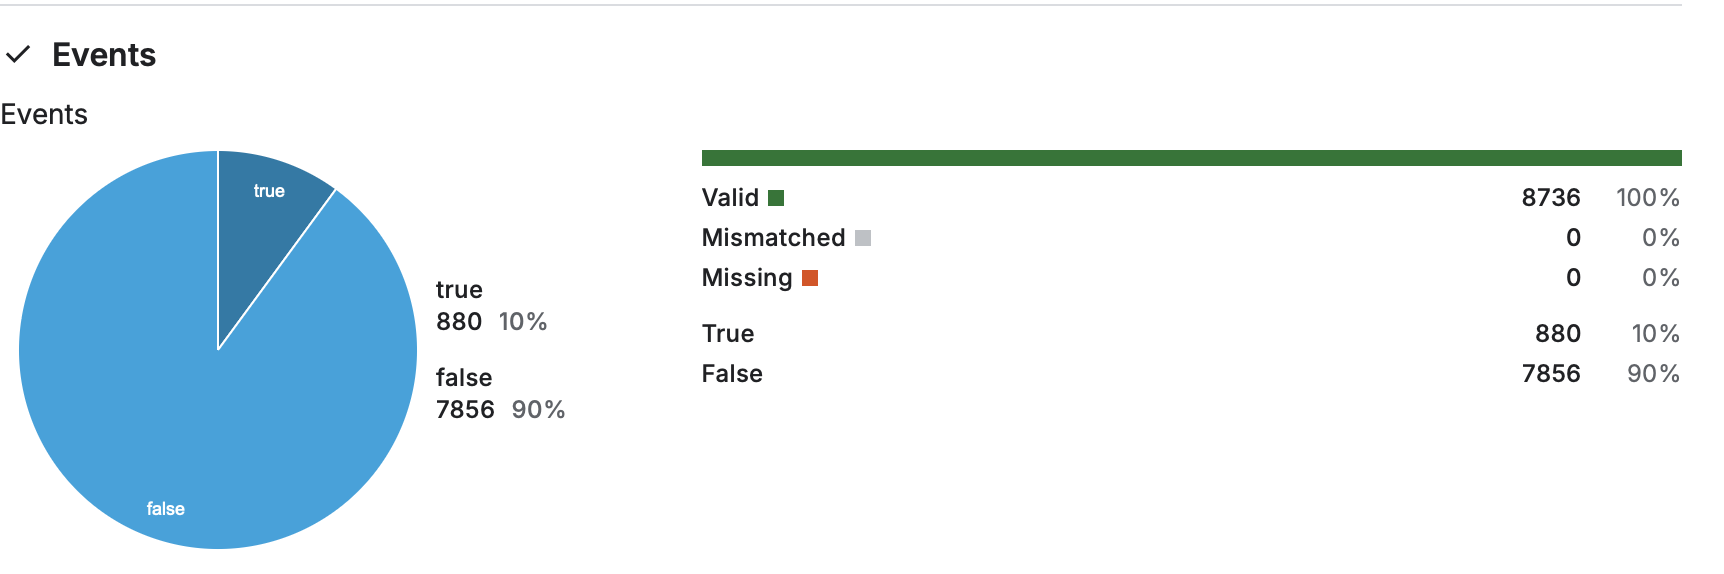

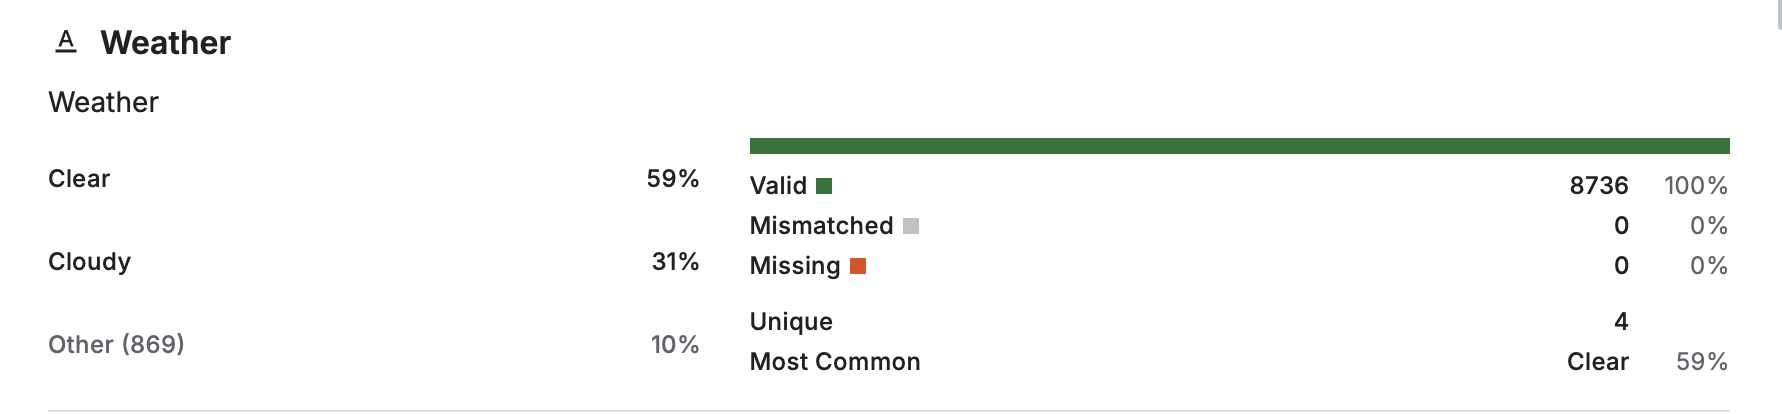

In [5]:
df.head()

,Timestamp,Weather,Events,Traffic Volume
0,2023-01-01 00:00:00,Cloudy,False,803.0
1,2023-01-01 01:00:00,Clear,False,861.0
2,2023-01-01 02:00:00,Clear,False,582.0
3,2023-01-01 03:00:00,Cloudy,False,236.0
4,2023-01-01 04:00:00,Cloudy,False,569.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8736 entries, 0 to 8735
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       8736 non-null   datetime64[ns]
 1   Weather         8736 non-null   object        
 2   Events          8736 non-null   bool          
 3   Traffic Volume  8736 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(1), object(1)
memory usage: 213.4+ KB


In [11]:
df=df.set_index("Timestamp")

In [15]:
colimn_name=[ 'Weather', 'Events']
for i in colimn_name:
  print(df[i].value_counts())

Weather
Clear     5164
Cloudy    2703
Rain       778
Snow        91
Name: count, dtype: int64
8736
Events
False    7856
True      880
Name: count, dtype: int64
8736


In [16]:
df.describe()

,Traffic Volume
count,8736.000000
mean,1281.395833
std,727.291462
min,118.000000
25%,893.000000
50%,1123.000000
75%,1415.000000
max,6465.000000


In [22]:
df.describe(include='object')

,Weather
count,8736
unique,4
top,Clear
freq,5164


In [23]:
df.isnull().sum()

,0
Weather,0
Events,0
Traffic Volume,0


In [24]:
df.duplicated().sum()

4861

<Axes: >

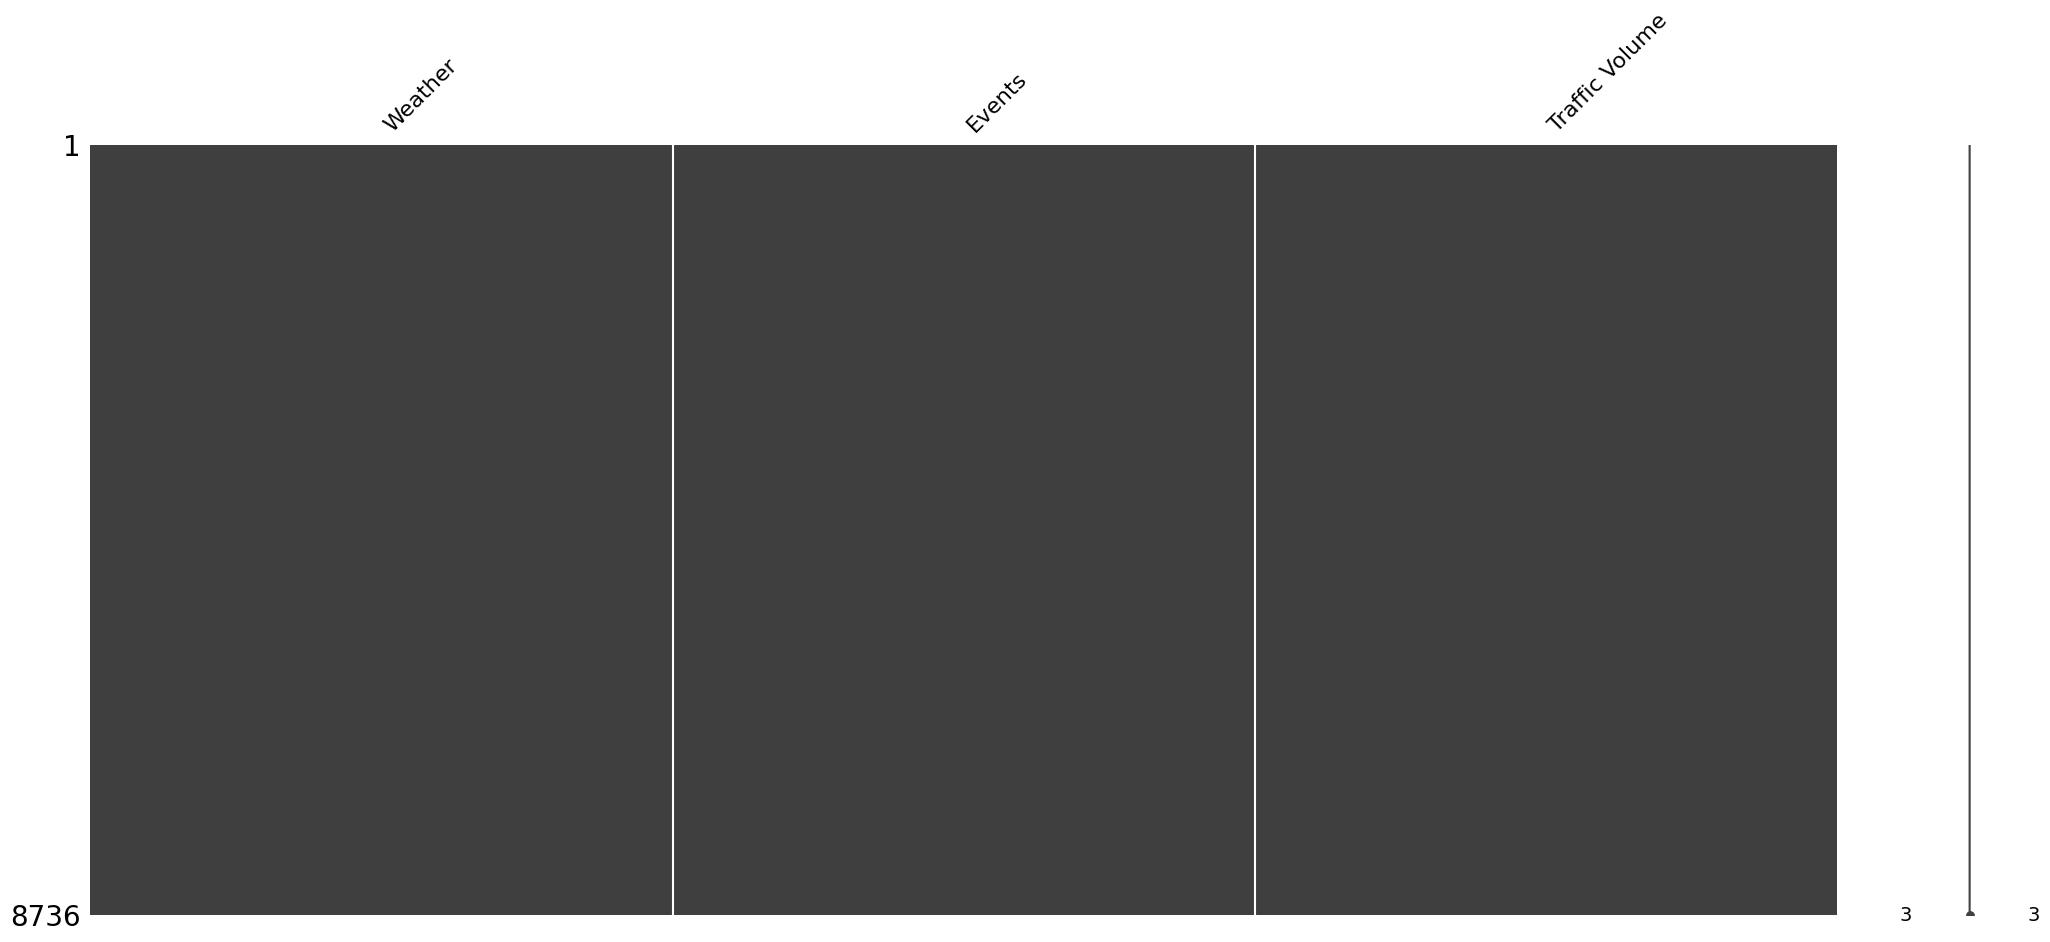

In [25]:
import missingno as msno
msno.matrix(df)

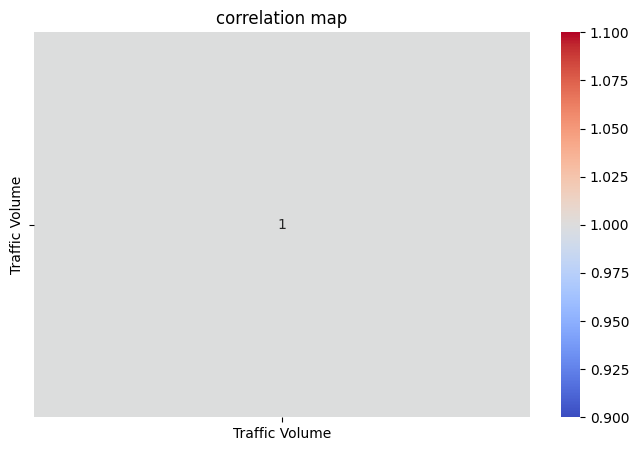

In [69]:
numerical_features = df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(8, 5))
sns.heatmap(numerical_features.corr(),annot=True ,cmap="coolwarm")
plt.title("correlation map")
plt.show()


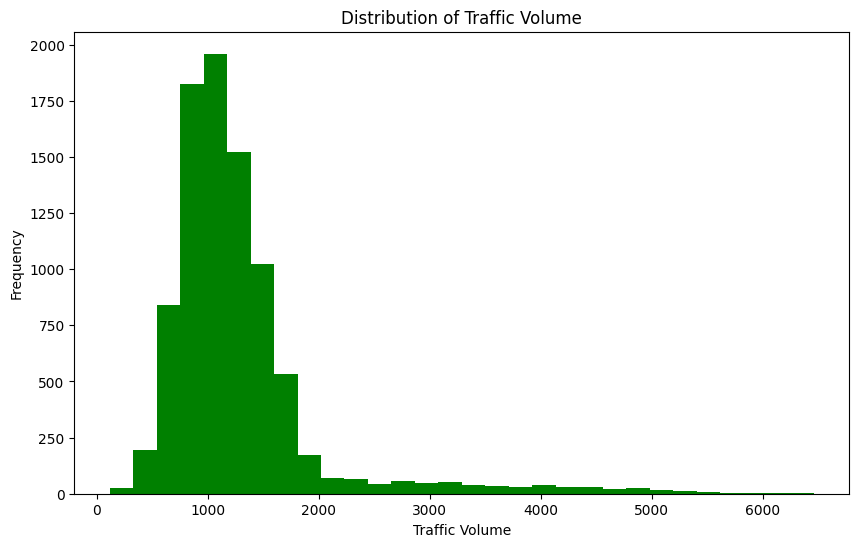

In [84]:
plt.figure(figsize=(10, 6))
plt.hist(df['Traffic Volume'], bins=30, color='green')
plt.title('Distribution of Traffic Volume')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.show()

In [30]:
train=df.loc["2023-01-01":"2023-09-30"]
val=df.loc["2023-10-01":"2023-11-15"]
test=df.loc["2023-11-16":]
print(train.shape,val.shape,test.shape)

(6552, 3) (1104, 3) (1080, 3)


In [32]:
from sklearn.model_selection import train_test_split
train_val,test=train_test_split(df,test_size=1080,shuffle=False)
train,val=train_test_split(train,test_size=1104,shuffle=False)

In [33]:
df.columns

Index(['Weather', 'Events', 'Traffic Volume'], dtype='object')

In [34]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.compose import make_column_transformer

perprocessing_pip=make_column_transformer(
    (MinMaxScaler(),["Traffic Volume"]),
    (OneHotEncoder(),['Weather', 'Events'])
)

In [36]:
train_pre=perprocessing_pip.fit_transform(train)
val_pre=perprocessing_pip.transform(val)
test_pre=perprocessing_pip.transform(test)

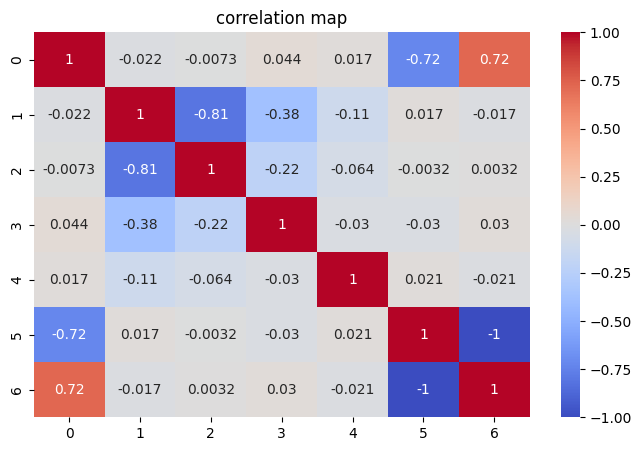

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert train_pre to a Pandas DataFrame
train_pre_df = pd.DataFrame(train_pre)

plt.figure(figsize=(8, 5))
sns.heatmap(train_pre_df.corr(), annot=True, cmap="coolwarm")
plt.title("correlation map")
plt.show()

In [39]:
import tensorflow as tf
from tensorflow.keras.utils import timeseries_dataset_from_array
window_size=30

train_xy = timeseries_dataset_from_array(train_pre, targets=train_pre[window_size:,0], sequence_length=window_size,batch_size=1024)
val_xy = timeseries_dataset_from_array(val_pre, targets=val_pre[window_size:,0], sequence_length=window_size,batch_size=1024)
test_xy= timeseries_dataset_from_array(test_pre, targets=test_pre[window_size:,0], sequence_length=window_size,batch_size=1024)

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,Bidirectional, GaussianNoise ,GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
model=Sequential([
        GRU(50,activation="relu",return_sequences=True),
        GRU(30,activation="relu",return_sequences=True),
        GRU(30,activation="relu")
        Dense(1,activation="relu")

])


In [64]:
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                          │ (None, None, 50)            │           8,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 30)                  │           7,380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,785 (190.57 KB)

 Trainable params: 16,261 (63.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 32,524 (127.05 KB)

None


In [54]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [55]:
model.compile(loss="mse",optimizer="adam",metrics=["mae"])

In [56]:
history=model.fit(train_xy,validation_data=val_xy,epochs=100,batch_size=128,callbacks=early_stopping)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 991ms/step - loss: 0.0250 - mae: 0.1087 - val_loss: 0.0172 - val_mae: 0.0766
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 372ms/step - loss: 0.0147 - mae: 0.0745 - val_loss: 0.0160 - val_mae: 0.0880
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - loss: 0.0163 - mae: 0.0940 - val_loss: 0.0150 - val_mae: 0.0807
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 372ms/step - loss: 0.0146 - mae: 0.0816 - val_loss: 0.0151 - val_mae: 0.0712
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 395ms/step - loss: 0.0138 - mae: 0.0693 - val_loss: 0.0158 - val_mae: 0.0709
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 506ms/step - loss: 0.0140 - mae: 0.0667 - val_loss: 0.0153 - val_mae: 0.0695
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 773ms/step - loss: 0.0136 - mae: 0.0665 - val_loss: 0.0144 - val_mae: 0.0696
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 393ms/step - loss: 0.0133 - mae: 0.0698 - val_loss: 0.0140 - val_mae: 0.0715
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 416ms/step - loss: 0.013

<Axes: >

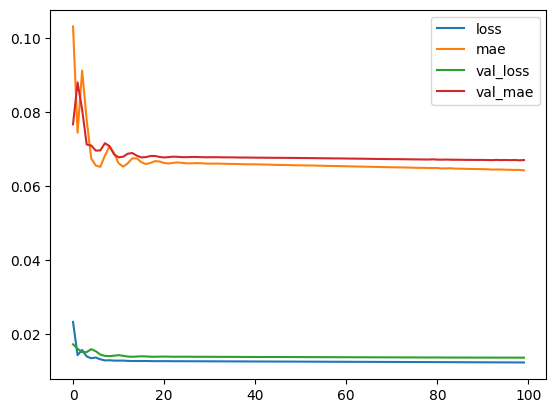

In [57]:
import pandas as pd
pd.DataFrame(history.history).plot()

In [58]:
model.predict(test_xy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


array([[0.16378684],
       [0.15673381],
       [0.15912639],
       ...,
       [0.18245734],
       [0.17153145],
       [0.16536573]], dtype=float32)

In [59]:
model.evaluate(test_xy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0127 - mae: 0.0678 


[0.012670036405324936, 0.06783055514097214]

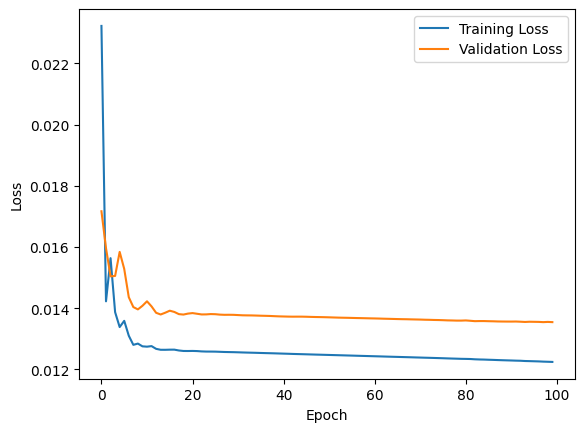

In [62]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
